In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
cwd = os.getcwd()
path = os.getcwd() + '/drive/MyDrive/ML/TFLearn/'
# os.chdir(path)
# !unzip '/content/drive/MyDrive/DL_Course/HM_3_Part_2/glove.6B.zip'
# os.chdir(cwd)
# del cwd

Mounted at /content/drive


In [3]:
# path = "./"

def train_val_split(dataset , split = 0.2):
    train_idx , val_idx = train_test_split(list(range(len(dataset))), test_size = split)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)
    return train_set, val_set

def confusion_matrix(true, pred):
    uniq = np.unique(true)
    mat = np.zeros((len(uniq),len(uniq)))
    for i in range(len(uniq)):
        indicies = np.where(uniq[i] == true)
        for j in range(len(uniq)):
            mat[i,j] = len(np.where(pred[indicies] == uniq[j])[0])
    return mat

def classwise_acc(mat):
    return mat.diagonal() / mat.sum(1)

def classwise_conf_matix(mat):
    l = []
    for i in range(len(mat)):
        a = np.array([[mat[i,i],mat[i,:].sum() - mat[i,i]],[ mat[:,i].sum() - mat[i,i],mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]]])
        l.append(a)
    return l

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = datasets.CIFAR10(root=path + 'data', train=True,
                                        download=True, transform=transform)

testset = datasets.CIFAR10(root=path + 'data', train=False,
                                       download=True, transform=transform)

trainset, valset = train_val_split(trainset, split  = 0.2)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader =  torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = models.vgg16(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
for params in model.parameters():
    params.require_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088,4096)),
    ('relu1',nn.ReLU()),
    ('fc2',nn.Linear(4096,2048)),
    ('relu2',nn.ReLU()),
    ('fc3',nn.Linear(2048,2048)),
    ('relu3',nn.ReLU()),
    ('fc4',nn.Linear(2048,2048)),
    ('relu4',nn.ReLU()),
    ('fc5',nn.Linear(2048,2048)),
    ('relu5',nn.ReLU()),
    ('fc6',nn.Linear(2048,2048)),
    ('relu6',nn.ReLU()),
    ('fc7', nn.Linear(2048,10)),
    ('output',nn.LogSoftmax(dim = 1))
    ]))
model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

epochs = 20
train_loss = []
val_loss  = []
verbose_idx = 20
train = False
val = True

In [7]:
if train :
    for e in range(epochs):
        running_loss = 0
        model.train()
        for idx, data in enumerate(trainloader):
            features = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            logps = model(features)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (idx %verbose_idx == 0):
                print("Epoch: {}, Idx: {}, Train Loss: {}".format(e,idx,loss.item()))
        train_loss.append(running_loss/len(trainloader))
        running_loss = 0
        acc = 0 
        model.eval()
        with torch.no_grad():
            if val : 
                for idx, data in enumerate(valloader):
                    features = data[0].to(device)
                    labels = data[1].to(device)

                    logps = model(features)
                    loss = criterion(logps, labels)
                    running_loss += loss.item()
                    var = torch.exp(logps).max(1)[1]
                    acc += var.eq(labels.data.view_as(var)).sum()
                val_loss.append(running_loss/len(valloader))
                print("Epoch: {}, Train Loss: {}, Test Loss: {}, Acc: {}".format(e,train_loss[-1],val_loss[-1],acc/len(valloader.dataset)))
        params = {'state_dict': model.state_dict() , 'train_loss': train_loss,  'val_loss': val_loss}
        torch.save(params, path + "modified_vgg16.pth")
        print("Model Saved")
else :
    params = torch.load(path + 'modified_vgg16.pth')
    train_loss = params['train_loss']
    val_loss = params['val_loss']
    model.load_state_dict(params['state_dict'])

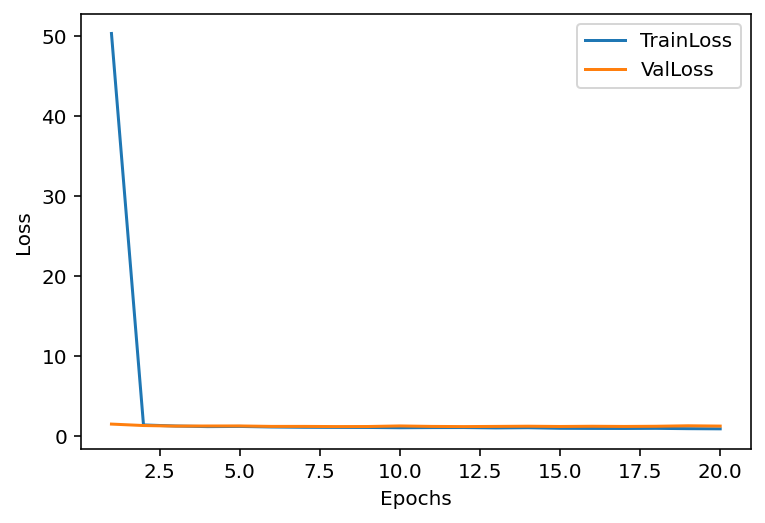

In [8]:
x = np.array(list(range(len(train_loss)))) + 1
plt.plot(x,train_loss,label = 'TrainLoss')
plt.plot(x,val_loss,label = "ValLoss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test Accuracy & Confusion Matrix


Test Accuracy: 0.6243000030517578


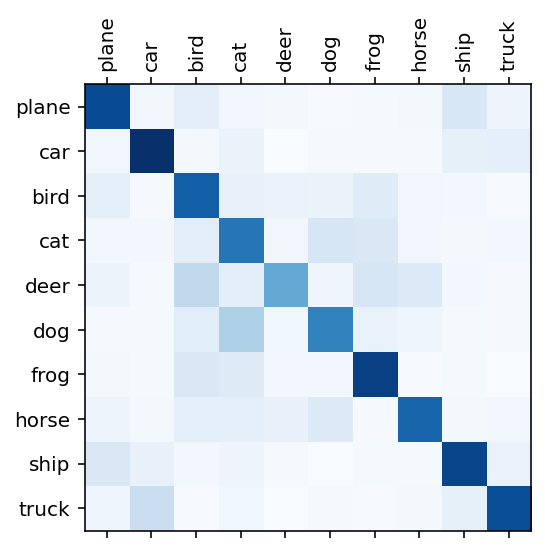

[[682.  25.  72.  24.  13.   4.  10.  17. 117.  36.]
 [ 24. 763.  13.  48.   0.   8.   6.   6.  63.  69.]
 [ 70.   6. 623.  59.  51.  49.  92.  26.  21.   3.]
 [ 23.  22.  79. 560.  24. 122. 108.  26.  15.  21.]
 [ 41.  10. 202.  72. 398.  31. 120. 102.  18.   6.]
 [  7.  10.  81. 250.  27. 521.  53.  34.  11.   6.]
 [ 13.  11. 112.  93.  21.  21. 713.   5.  10.   1.]
 [ 38.  17.  67.  67.  55. 103.   8. 609.  12.  24.]
 [113.  56.  21.  36.   7.   0.   9.   9. 698.  51.]
 [ 31. 168.   5.  29.   2.   7.   3.  15.  64. 676.]]


In [13]:
label_GT = np.zeros((0,))
label_pred = np.zeros((0,))
acc = 0
model.eval()
with torch.no_grad():
    for idx, data in enumerate(testloader):
        
        features, labels = data[0].to(device), data[1].to(device)
        pred = torch.exp(model(features)).data.max(1)[1]

        label_GT = np.concatenate([label_GT, labels.cpu().numpy()])
        label_pred = np.concatenate([label_pred, pred.cpu().numpy()])
        acc += pred.eq(labels.data.view_as(pred)).sum()
    
print("Test Accuracy: {}".format(acc / len(testloader.dataset)))
mat = confusion_matrix(label_GT , label_pred)
plt.matshow(mat/mat.sum(1),cmap = plt.cm.Blues)
plt.xticks(range(10),classes, rotation = 'vertical')
plt.yticks(range(10),classes)
plt.show()
print(mat)



### Classwise Accuracy and Classwise Confusion Matrix

In [14]:
cw_acc = classwise_acc(mat)
cw_mats = classwise_conf_matix(mat)

[0.682 0.763 0.623 0.56  0.398 0.521 0.713 0.609 0.698 0.676]


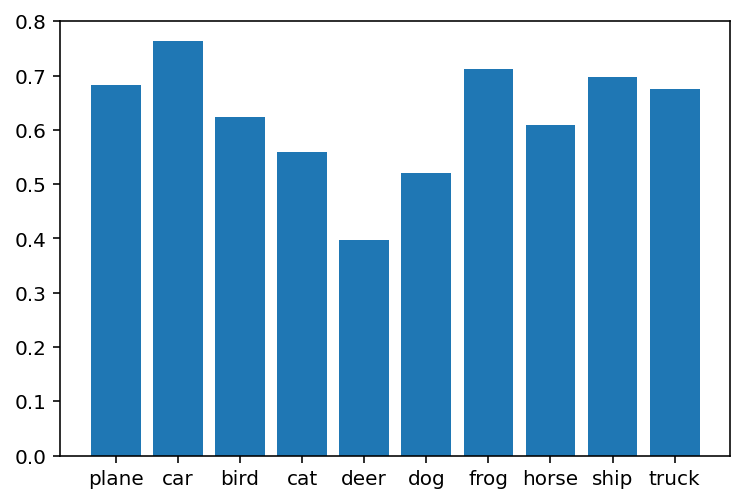

In [15]:
fig, ax = plt.subplots()
print(cw_acc)
b1 = ax.bar(classes,cw_acc,label = "Accuracy")
# ax.bar_label(b1)
plt.show()

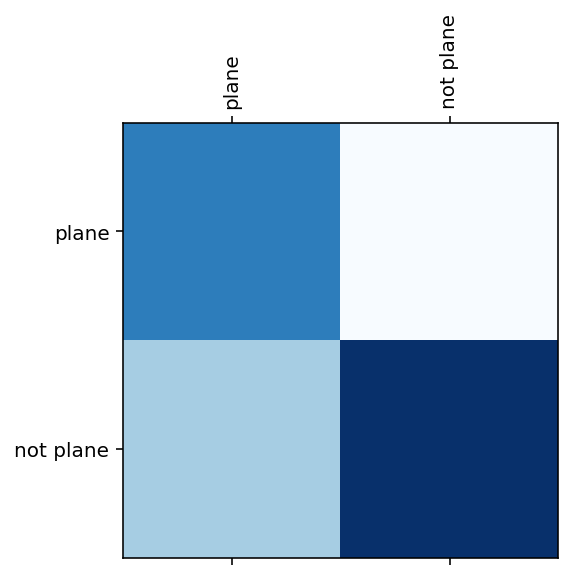

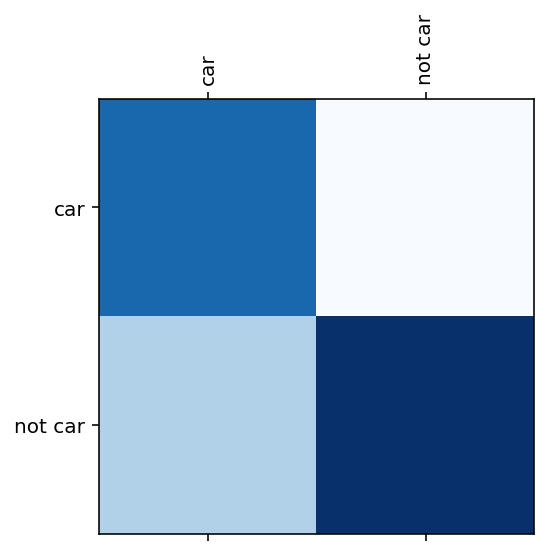

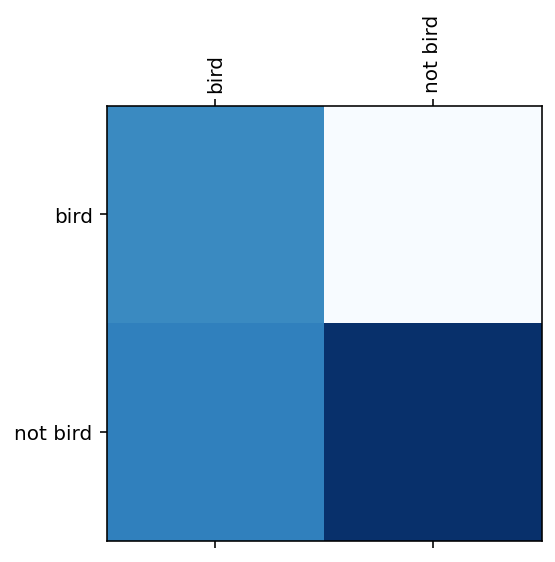

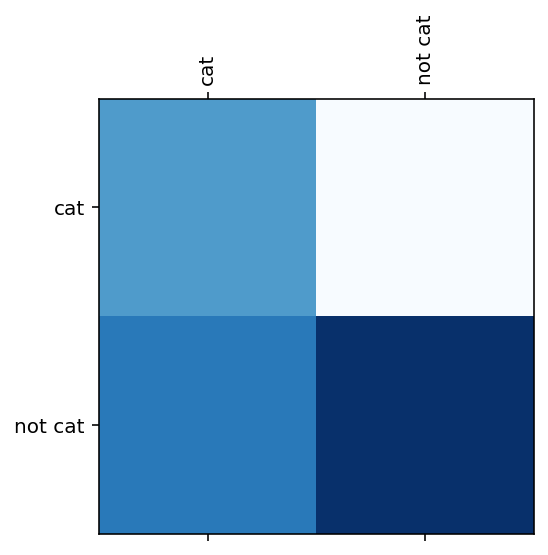

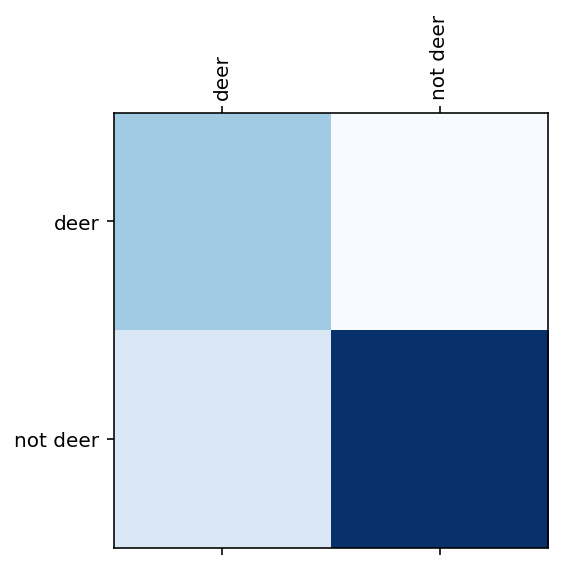

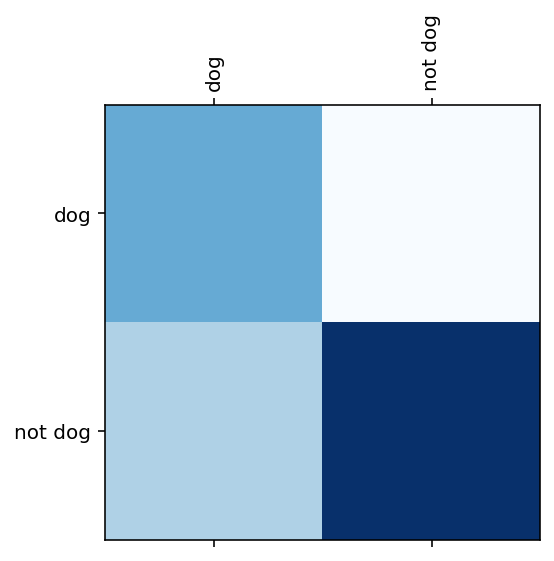

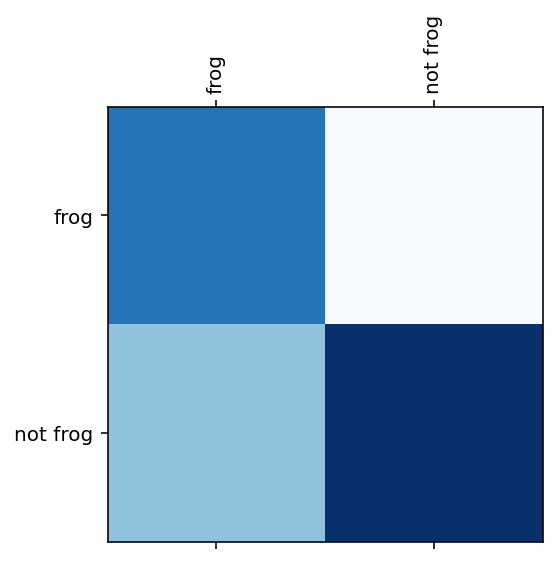

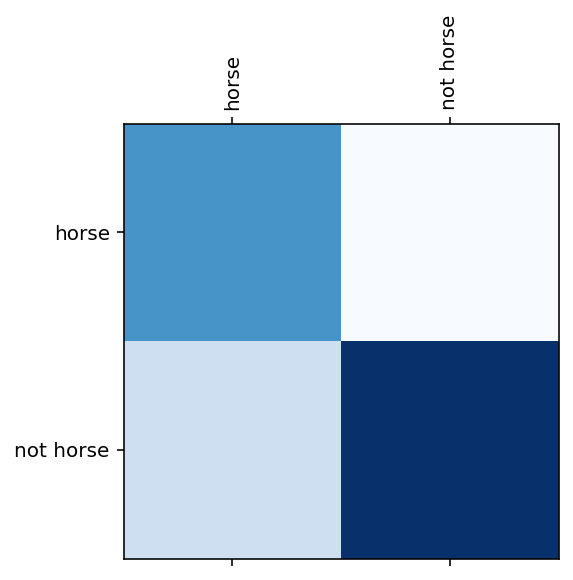

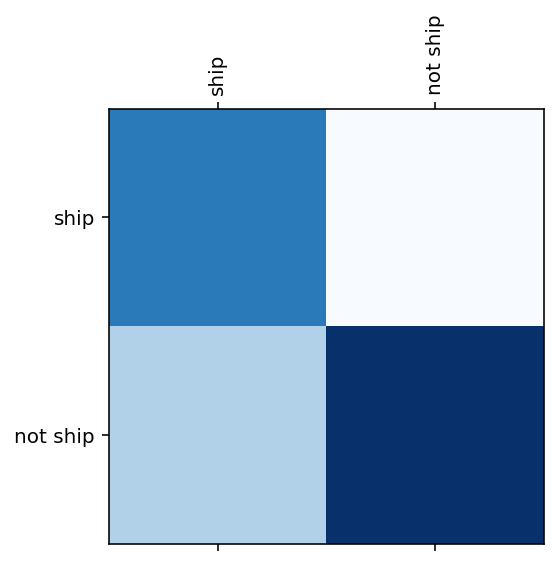

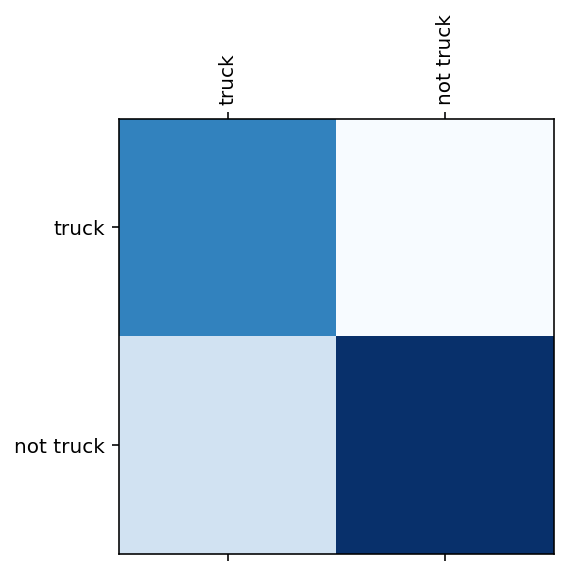

[[0.682      0.03533333]
 [0.36       0.96      ]]
[[0.763      0.02633333]
 [0.325      0.96388889]]
[[0.623      0.04188889]
 [0.652      0.92755556]]
[[0.56       0.04888889]
 [0.678      0.92466667]]
[[0.398      0.06688889]
 [0.2        0.97777778]]
[[0.521      0.05322222]
 [0.345      0.96166667]]
[[0.713      0.03188889]
 [0.409      0.95455556]]
[[0.609      0.04344444]
 [0.24       0.97333333]]
[[0.698      0.03355556]
 [0.331      0.96322222]]
[[0.676      0.036     ]
 [0.217      0.97588889]]


In [20]:
# plt.subplots(10,1)
l = cw_mats
for i in range(10):
    plt.matshow(l[i]/l[i].sum(1),cmap = plt.cm.Blues,fignum = 0)
    plt.xticks(range(2),[classes[i],'not ' + classes[i]], rotation='vertical')
    plt.yticks(range(2),[classes[i],'not ' + classes[i]])
    plt.show()
for i in range(10):
    print(l[i]/l[1].sum(1))